In [1478]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
import yfinance as yf
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from scipy.integrate import trapz
from scipy.misc import derivative
from scipy.integrate import simps
from scipy.optimize import curve_fit

In [1479]:
def option_value(option_type, S, K, sigma, t=0, r=0):
    """
    Calculate the value of an option using the Black-Scholes model
    
    :param option_type: "call"/"c" or "put"/"p"
    :type option_type: str
    :param S: price of the underlying
    :type S: float
    :param K: strike price of option
    :type K: float
    :param sigma: input implied volatility
    :type sigma: float
    :param t: time to expiration
    :type t: float, optional
    :param r: risk-free rate
    :type r: float, optional
    """
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        d2 = d1 - sigma * np.sqrt(t)
    if option_type.lower() in {"c", "call"}:
        return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * t))
    elif option_type.lower() in {"p", "put"}:
        return -np.multiply(norm.cdf(-d1), S) + np.multiply(norm.cdf(-d2), K * np.exp(-r * t))

In [1480]:
calls = pd.read_excel("SPY_191020exp_290920.xlsx", sheet_name="call")
calls["midprice"] = (calls.bid + calls.ask)/2
calls = calls[calls.midprice > 0]
calls

,strike,lastPrice,change,bid,ask,BxA,volume,openInterest,midprice
0,170,0.00,0.0,163.70,164.06,146 x 146,0,0,163.880
1,175,0.00,0.0,158.70,159.06,146 x 146,0,0,158.880
2,180,0.00,0.0,153.69,154.05,146 x 102,0,0,153.870
3,185,0.00,0.0,148.70,149.04,146 x 102,0,0,148.870
4,190,0.00,0.0,143.70,144.06,146 x 146,0,0,143.880
...,...,...,...,...,...,...,...,...,...
110,405,0.01,0.0,0.00,0.01,0 x 11065,0,28,0.005
111,410,0.02,0.0,0.00,0.01,0 x 8620,0,200,0.005
112,415,0.01,0.0,0.00,0.01,0 x 8630,0,5,0.005
113,420,0.02,0.0,0.00,0.01,0 x 8641,0,55,0.005


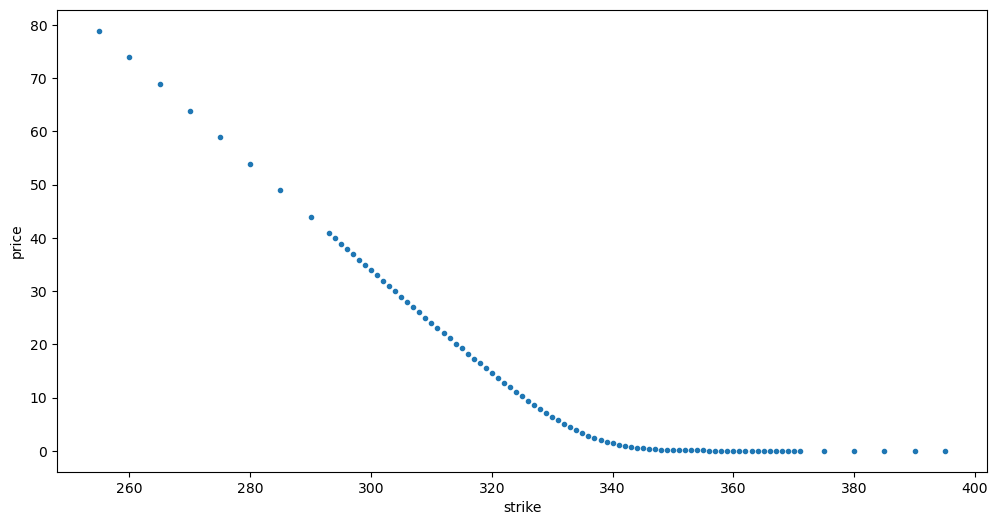

In [1481]:
calls_sub = calls[(calls.strike > 250) & (calls.strike < 400)]
plt.figure(figsize=(12,6))
plt.plot(calls_sub.strike, calls_sub.midprice, ".");
plt.xlabel("strike")
plt.ylabel("price")
#plt.savefig("call_prices.png", dpi=400)
plt.show()

## Implied Volatility Surface

In [1482]:
def call_value(S, K, sigma, t=0, r=0):
    # use np.multiply and divide to handle divide-by-zero
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        d2 = d1 - sigma * np.sqrt(t)
    return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * t))

def call_vega(S, K, sigma, t=0, r=0):
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
    return np.multiply(S, norm.pdf(d1)) * np.sqrt(t)

def bs_iv(price, S, K, t=0, r=0, precision=1e-4, initial_guess=0.2, max_iter=1000, verbose=False):
    iv = initial_guess
    for _ in range(max_iter):
        P = call_value(S, K, iv, t, r)
        diff = price - P
        if abs(diff) < precision:
            return iv
        grad = call_vega(S, K, iv, t, r)
        iv += diff/grad     
    if verbose:
        print(f"Did not converge after {max_iter} iterations")
    return iv 

In [1483]:
S = 332
t = 3/52
calls["iv"] = calls.apply(lambda row: bs_iv(row.midprice, S, row.strike, t, max_iter=500), axis=1)

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_10124\2692504730.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  iv += diff/grad
C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_10124\2692504730.py:4: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_10124\2692504730.py:10: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)


In [1484]:
def plot_vol_smile(calls, savefig=False):
    plt.figure(figsize=(9,6))
    plt.plot(calls.strike, calls.iv, ".")
    plt.xlabel("Strike")
    plt.ylabel("IV")
    if savefig:
        plt.savefig("vol_smile.png",dpi=300)
    plt.show()

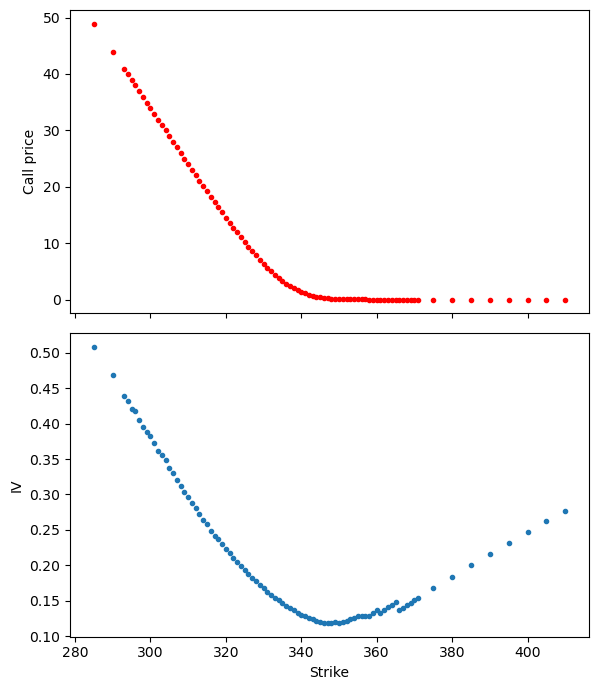

In [1485]:
calls_no_na = calls.dropna()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,7), sharex=True)
ax1.plot(calls_no_na.strike, calls_no_na.midprice, "r.")
ax1.set_ylabel("Call price")
ax2.plot(calls_no_na.strike, calls_no_na.iv, ".")
ax2.set_ylabel("IV")
ax2.set_xlabel("Strike")
plt.tight_layout()
# plt.savefig("calls_to_iv.png", dpi=400)
plt.show()

In [1486]:
calls_clean = calls.dropna().copy()
calls_clean["iv"] = gaussian_filter1d(calls_clean.iv, 3)

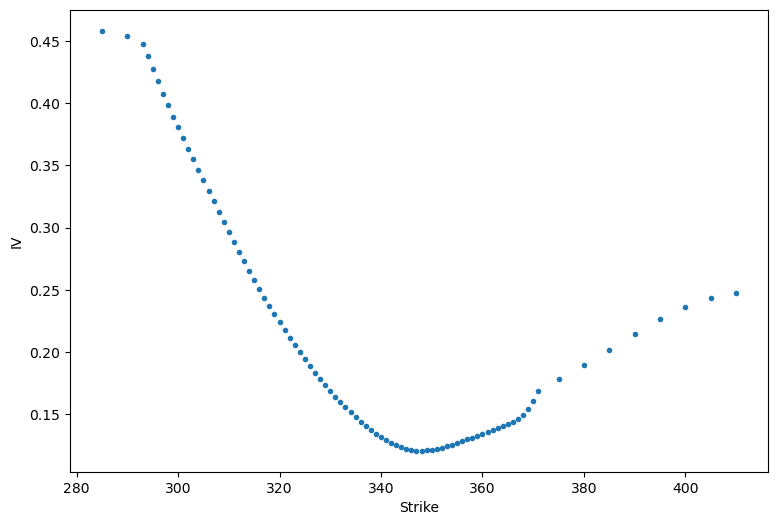

In [1487]:
plot_vol_smile(calls_clean)

In [1488]:
calls_clean = calls_clean[(calls_clean.strike > 300) & (calls_clean.strike < 375)]

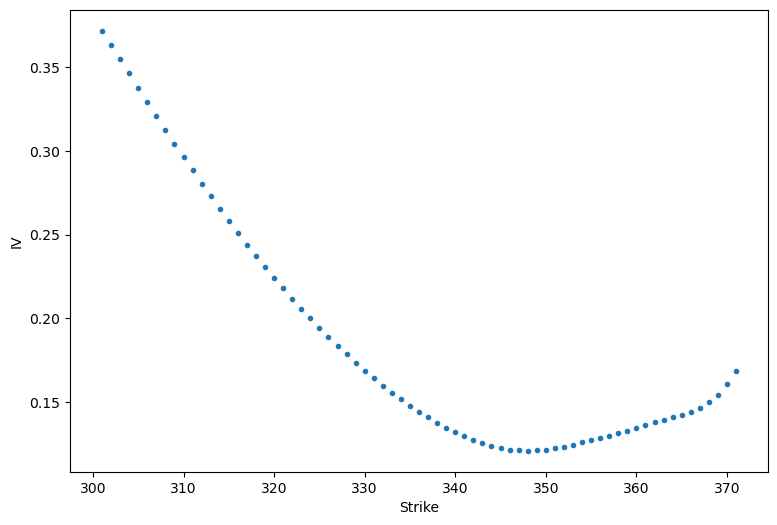

In [1489]:
plot_vol_smile(calls_clean, savefig=False)

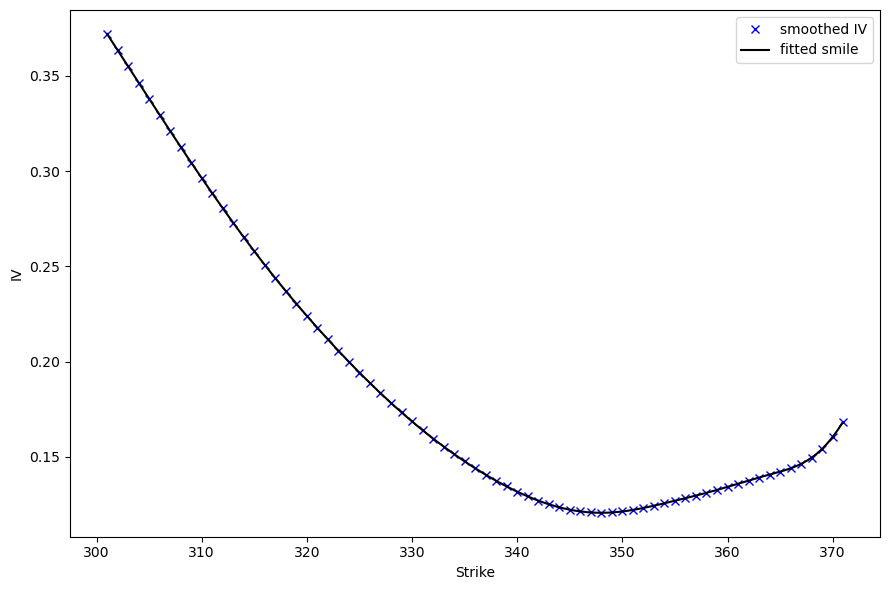

In [1490]:
plt.figure(figsize=(9,6))
vol_surface = scipy.interpolate.interp1d(calls_clean.strike, calls_clean.iv, kind="cubic",
                                 fill_value="extrapolate")
x_new = np.arange(calls_clean.strike.min(), calls_clean.strike.max(), 0.1)
plt.plot(calls_clean.strike, calls_clean.iv, "bx", x_new, vol_surface(x_new), "k-");
plt.legend(["smoothed IV", "fitted smile"], loc="best")
plt.xlabel("Strike")
plt.ylabel("IV")
plt.tight_layout()
# plt.savefig("SPY_smile.png", dpi=300)
plt.show()

In [1491]:
C_interp = call_value(S, x_new, vol_surface(x_new), t)

In [1492]:
first_deriv = np.gradient(C_interp, x_new)
second_deriv = np.gradient(first_deriv, x_new)

In [1493]:
def pdf2(Krange, S, t=0, r=0):
    # x is a range of strikes
    Crange = call_value(S, Krange, vol_surface(Krange), t, r)
    first_deriv = np.gradient(Crange, x_new, edge_order=0)
    second_deriv = np.gradient(first_deriv, x_new, edge_order=0)
    return np.exp(r * t) * second_deriv

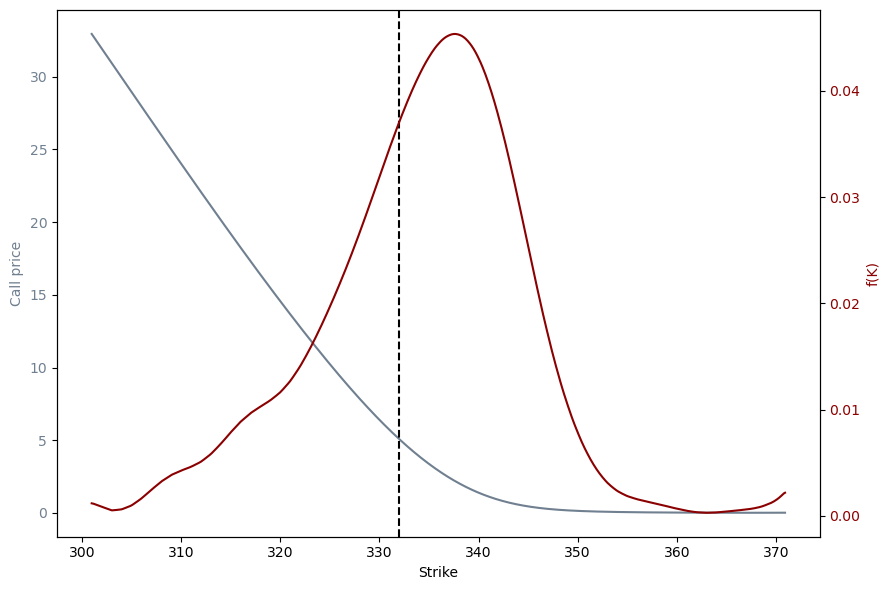

In [1494]:
fig, ax1 = plt.subplots(figsize=(9,6))

col="slategrey"
ax1.set_xlabel('Strike')
ax1.set_ylabel('Call price', color=col)
ax1.plot(x_new, C_interp, color=col)
ax1.tick_params(axis='y', labelcolor=col)
ax1.axvline(332, color="k", linestyle="--")

ax2 = ax1.twinx()
col = 'darkred'
ax2.set_ylabel('f(K)', color=col)
ax2.plot(x_new, pdf2(x_new, S, t), color=col)
ax2.tick_params(axis='y', labelcolor=col)

fig.tight_layout()
# plt.savefig("volspace_pdf.png", dpi=300)
plt.show()

In [1495]:
data = np.vstack([x_new, pdf2(x_new, S, t)]).T
data = data[(data[:, 0] < 360) & (data[:, 0] > 320)]
k, curve_pdf = np.hsplit(data, 2)

#### Create 2D array

In [1496]:
# Flatten the arrays if they are 2D
k_flat = k.flatten()
curve_pdf_flat = curve_pdf.flatten()

# Create a 2D array for the original PDF
original_pdf = np.column_stack((k_flat, curve_pdf_flat))

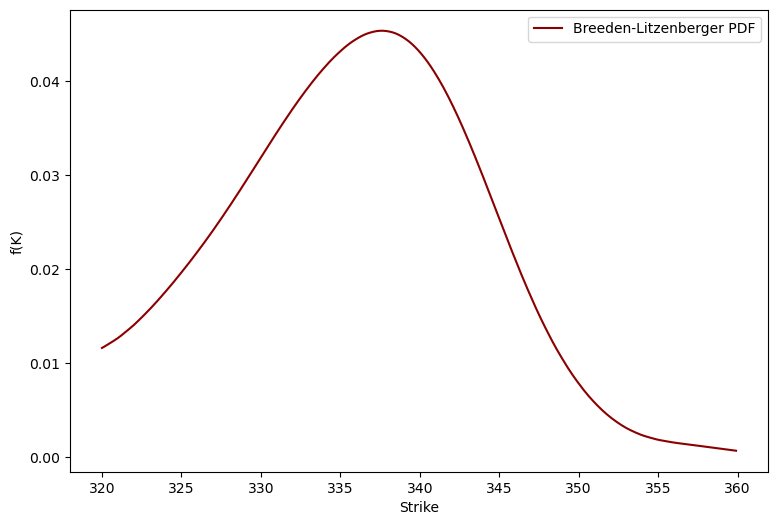

In [1497]:
plt.figure(figsize=(9,6))
plt.plot(original_pdf[:, 0], original_pdf[:, 1], "darkred")
plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(["Breeden-Litzenberger PDF"], loc="best")
# plt.savefig("breeden_litzenberger_pdf.png", dpi=300)
plt.show()


C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_10124\3535132552.py:7: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * (x - c))


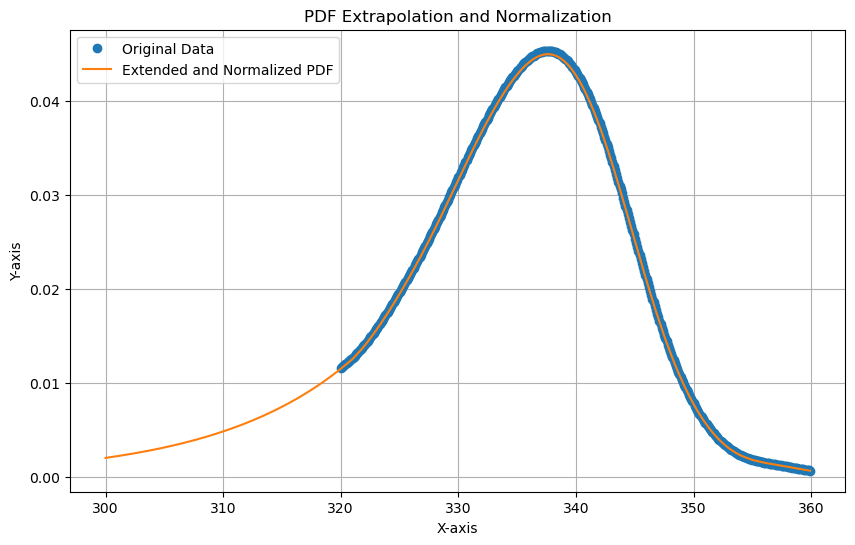

In [1498]:

# Separate the original data into x and y components for clarity
x_original = original_pdf[:, 0]
y_original = original_pdf[:, 1]

# Define the exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * (x - c))

# Use the leftmost points of the original data to fit the exponential decay
left_points_x = x_original[:10]  # Use more points if necessary for a better fit
left_points_y = y_original[:10]
params, _ = curve_fit(exp_decay, left_points_x, left_points_y, p0=(1, 1, x_original[0]))

# Define the range for extrapolation
x_min_extrapolate = 300  # Adjust this as needed

# Generate new x values for extrapolation
x_extrapolate = np.linspace(x_min_extrapolate, x_original[0], num=100, endpoint=False)

# Generate new y values using the fitted exponential decay
y_extrapolate = exp_decay(x_extrapolate, *params)

# Combine the extrapolated points with the original data
extrapolated_pdf = np.column_stack((x_extrapolate, y_extrapolate))
new_pdf = np.vstack((extrapolated_pdf, original_pdf))

# Normalize the curve so the total area is 1
x_values = new_pdf[:, 0]
y_values = new_pdf[:, 1]
area = simps(y_values, x_values)
y_values_normalized = y_values / area

# Replace the y-values in new_pdf with normalized values
new_pdf[:, 1] = y_values_normalized

# Plot the original and the new PDF
plt.figure(figsize=(10, 6))
plt.plot(x_original, y_original, 'o', label='Original Data')
plt.plot(new_pdf[:, 0], new_pdf[:, 1], label='Extended and Normalized PDF')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('PDF Extrapolation and Normalization')
plt.legend()
plt.grid(True)
plt.show()


In [1499]:
rn_pdf = new_pdf

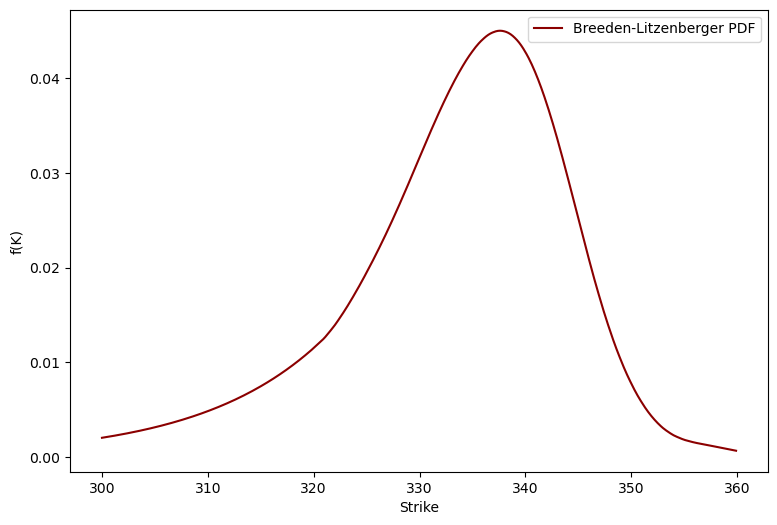

In [1500]:
plt.figure(figsize=(9,6))
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], "darkred")
plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(["Breeden-Litzenberger PDF"], loc="best")
# plt.savefig("breeden_litzenberger_pdf.png", dpi=300)
plt.show()


### Define payoffs and useful functions

In [1501]:
def reverse_convertible(x,K):
    if x <= K:
        return x
    else:
        return K 

In [1502]:
import numpy as np
import matplotlib.pyplot as plt

def reverse_convertible_payoff(S_T, S_0, P, C, K):
    """
    Calculates the payoff of a reverse convertible.

    Parameters:
    S_T: Price of the underlying asset at maturity.
    S_0: Initial price of the underlying asset.
    P: Principal amount.
    C: Coupon payment.
    K: Strike price.

    Returns:
    Total payoff of the reverse convertible.
    """
    # Adjusted asset value based on the initial price
    adjusted_asset_value = P * S_T / S_0

    # The investor receives the adjusted asset value if it's below the principal, 
    # otherwise they receive the principal amount.
    asset_or_principal = min(P, adjusted_asset_value)

    # Total payoff is the sum of the coupon payment and the minimum of principal or adjusted asset value.
    return C + asset_or_principal

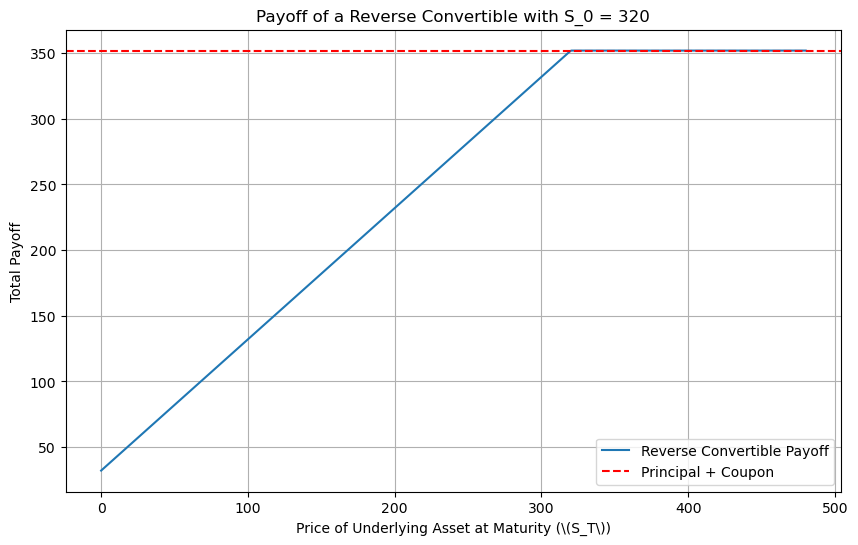

In [1503]:
##PLOT EXAMPLE 

# Parameters
S_0 = 320  # Initial price of the underlying asset
P = S_0  # Principal amount (equal to S_0)
C = P * 0.10  # Coupon payment (10% of principal)
K = P  # Strike price equal to the principal

# Price of the underlying asset at maturity ranging from 0 to 1.5 times the initial price
S_T_values = np.linspace(0, 1.5 * S_0, 500)

# Calculate payoffs
payoffs = [reverse_convertible_payoff(S_T, S_0, P, C, K) for S_T in S_T_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(S_T_values, payoffs, label='Reverse Convertible Payoff')
plt.axhline(y=P + C, color='r', linestyle='--', label='Principal + Coupon')
plt.title('Payoff of a Reverse Convertible with S_0 = 320')
plt.xlabel('Price of Underlying Asset at Maturity (\(S_T\))')
plt.ylabel('Total Payoff')
plt.legend()
plt.grid(True)
plt.show()


In [1504]:
#Function that is equal to F'(x)/F(x) for the reverse convertible
def derivative_to_payoff_ratio(S_T, S_0, P, C, K):
    """
    Calculates the ratio of the derivative of the reverse convertible payoff 
    to the payoff itself.

    Parameters:
    S_T: Price of the underlying asset at maturity.
    S_0: Initial price of the underlying asset.
    P: Principal amount.
    C: Coupon payment.
    K: Strike price.

    Returns:
    Ratio of the derivative of the payoff to the payoff itself.
    """
    # Calculate the reverse convertible payoff
    payoff = reverse_convertible_payoff(S_T, S_0, P, C, K)

    # Derivative is 1 before the strike and 0 after
    derivative = 1 if S_T < K else 0

    # Avoid division by zero
    if payoff == 0:
        return 0

    # Ratio calculation
    ratio = derivative / payoff if S_T < K else 0

    return ratio


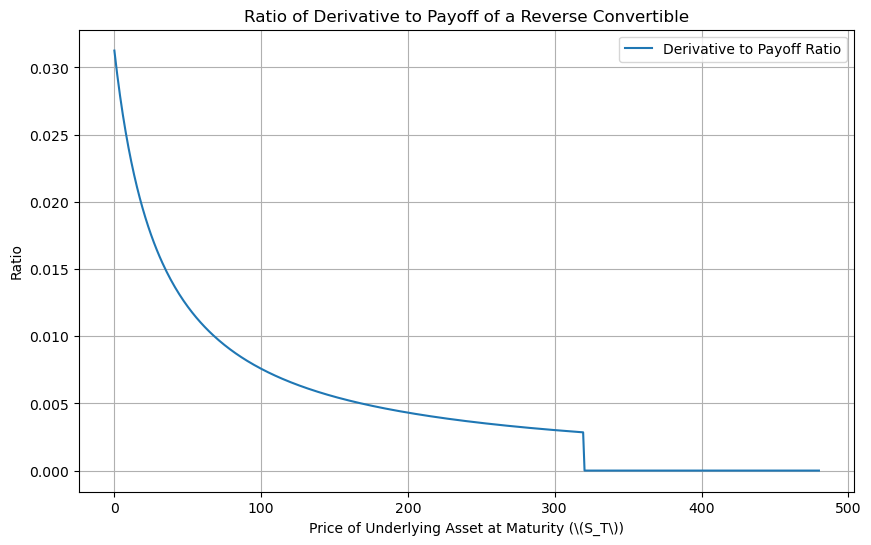

In [1505]:
# Plotting the ratio for the same range of S_T values
ratio_values = [derivative_to_payoff_ratio(S_T, S_0, P, C, K) for S_T in S_T_values]

plt.figure(figsize=(10, 6))
plt.plot(S_T_values, ratio_values, label='Derivative to Payoff Ratio')
plt.title('Ratio of Derivative to Payoff of a Reverse Convertible')
plt.xlabel('Price of Underlying Asset at Maturity (\(S_T\))')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.show()


In [1506]:

def ratio_function(x, growth_optimizer_payoff):
    # Function to compute the derivative
    def derivative_of_growth_optimizer(x):
        return derivative(growth_optimizer_payoff, x, dx=1e-6)
    
    # Function to compute the ratio of the original function to its derivative
    original_value = growth_optimizer_payoff(x)
    derivative_value = derivative_of_growth_optimizer(x)
    return original_value / derivative_value if derivative_value != 0 else np.inf

In [1507]:
def relative_risk_aversion(x, growth_optimizer_payoff, general_payoff_ratio):
    return ratio_function(x, growth_optimizer_payoff) * general_payoff_ratio(x)

# Change pdf beliefs

In [1508]:
#Measure the area under the pdf curves

def compute_area(pdf_array):
    """
    Compute the area under a given PDF represented as a 2D array.

    Parameters:
    pdf_array (numpy.ndarray): A 2D array where the first column contains the x-values (e.g., strike prices)
                               and the second column contains the corresponding PDF values.

    Returns:
    float: The area under the PDF curve.
    """
    x_values = pdf_array[:, 0]
    pdf_values = pdf_array[:, 1]
    area = trapz(pdf_values, x_values)
    return area

# Example usage:
area_under_rn_pdf = compute_area(rn_pdf)
print("Area under the PDF:", area_under_rn_pdf)


Area under the PDF: 1.0000016354197212


## Shift the pdf

In [1509]:
# Flatten the arrays if they are 2D
# Assuming rn_pdf is already a 2D array with the first column for x-values and the second for y-values
k_flat = rn_pdf[:, 0].flatten()  # This is the x-values of rn_pdf
curve_pdf_flat = rn_pdf[:, 1].flatten()  # This is the y-values of rn_pdf

In [1510]:
# Shift the rn_pdf to the right by "shift" units
shift = 5
shifted_pdf = np.column_stack((k_flat + shift, curve_pdf_flat))

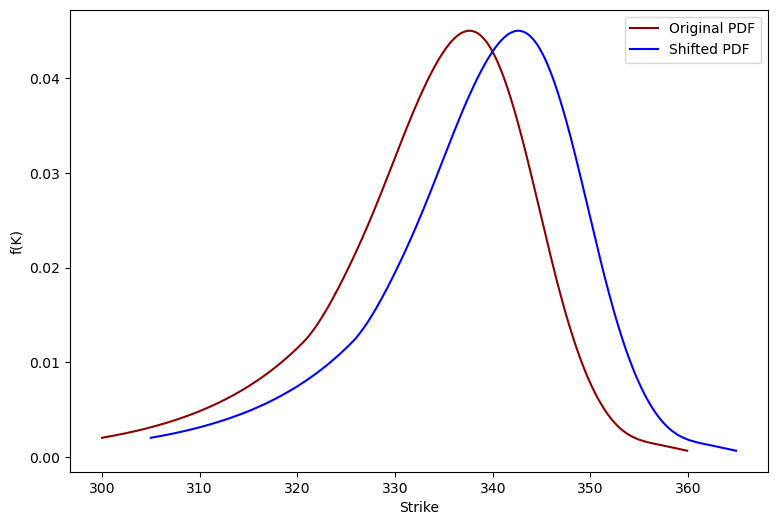

In [1511]:
# Plot the original and shifted PDFs
plt.figure(figsize=(9, 6))

# Plot the original PDF (rn_pdf)
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], "darkred", label="Original PDF")

# Plot the shifted PDF
plt.plot(shifted_pdf[:, 0], shifted_pdf[:, 1], "blue", label="Shifted PDF")

plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(loc="best")
plt.show()


In [1512]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF

# Interpolate the original PDF
rn_pdf_interp = interp1d(rn_pdf[:, 0], rn_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the shifted PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the shifted strike prices
rn_pdf_values_at_shifted = rn_pdf_interp(shifted_pdf[:, 0])

# Handle division by zero by replacing zeros with a very small number
division = np.where(rn_pdf_values_at_shifted != 0, shifted_pdf[:, 1] / rn_pdf_values_at_shifted, 0)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff_shift = interp1d(shifted_pdf[:, 0], division, kind='linear', fill_value='extrapolate')

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_10124\3301309537.py:11: RuntimeWarning: divide by zero encountered in true_divide
  division = np.where(rn_pdf_values_at_shifted != 0, shifted_pdf[:, 1] / rn_pdf_values_at_shifted, 0)


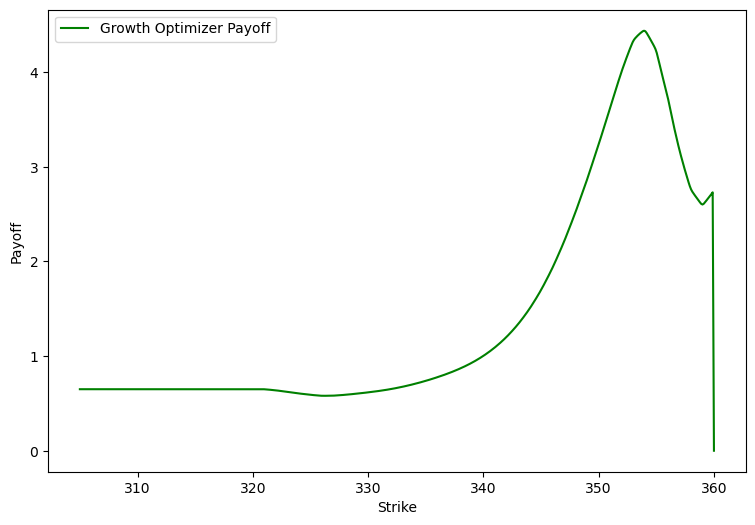

In [1513]:

# Define the end of the range for plotting
end_range = min(360, np.max(shifted_pdf[:, 0]))

# Use a range of strike prices for plotting, stopping at 360 or the last available data point
strike_range = np.linspace(np.min(shifted_pdf[:, 0]), end_range, 500)

# Plot the growth optimizer payoff function
plt.figure(figsize=(9, 6))
plt.plot(strike_range, growth_optimizer_payoff_shift(strike_range), 'green', label='Growth Optimizer Payoff')

# Set labels and legend
plt.xlabel("Strike")
plt.ylabel("Payoff")
plt.legend(loc="best")

# Optionally save the figure
# plt.savefig("growth_optimizer_payoff.png", dpi=300)

plt.show()


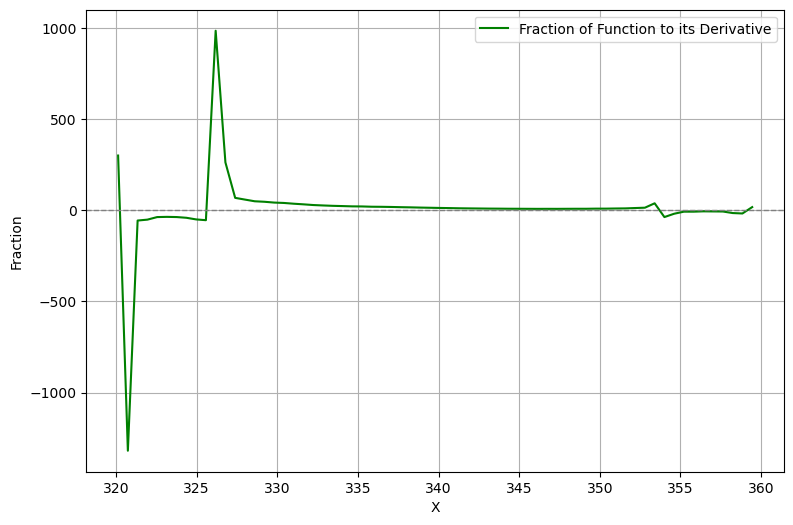

In [1514]:
# Define a range of x values for plotting
x_range = np.linspace(np.min(growth_optimizer_payoff_shift.x), np.max(growth_optimizer_payoff_shift.x), 100)

# Compute the ratio for each x value in the range
ratios = [ratio_function(x, growth_optimizer_payoff_shift) for x in x_range]

# Plot the ratio
plt.figure(figsize=(9, 6))
plt.plot(x_range, ratios, 'green', label='Fraction of Function to its Derivative')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True) 
# plt.savefig("function_to_derivative_fraction.png", dpi=300)
plt.show()

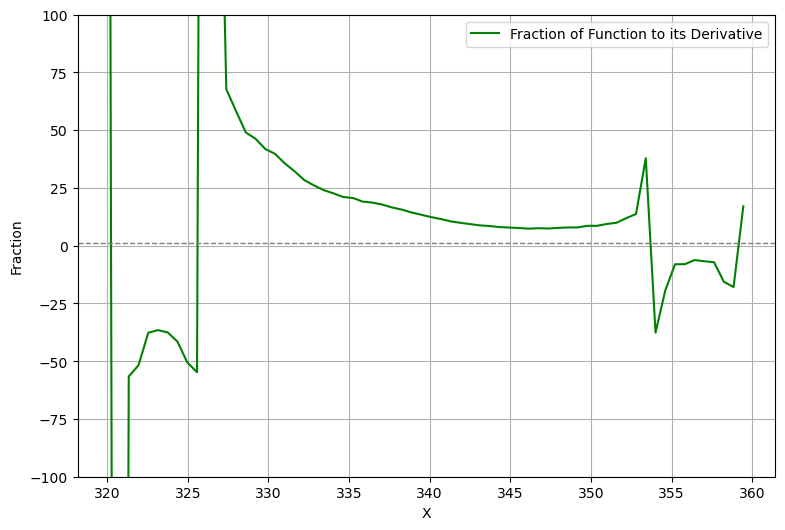

In [1515]:

# Define a range of x values for plotting
x_range = np.linspace(np.min(shifted_pdf[:, 0]), np.max(shifted_pdf[:, 0]), 100)

# Compute the ratio for each x value in the range
# Since growth_optimizer_payoff_shift is already a function, you don't need to wrap it with lambda
ratios = [ratio_function(x, growth_optimizer_payoff_shift) for x in x_range]

# Plot the ratio
plt.figure(figsize=(9, 6))
plt.plot(x_range, ratios, 'green', label='Fraction of Function to its Derivative')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)

# Set the vertical limit of the plot
plt.ylim(-100, 100)

plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True) 
plt.show()


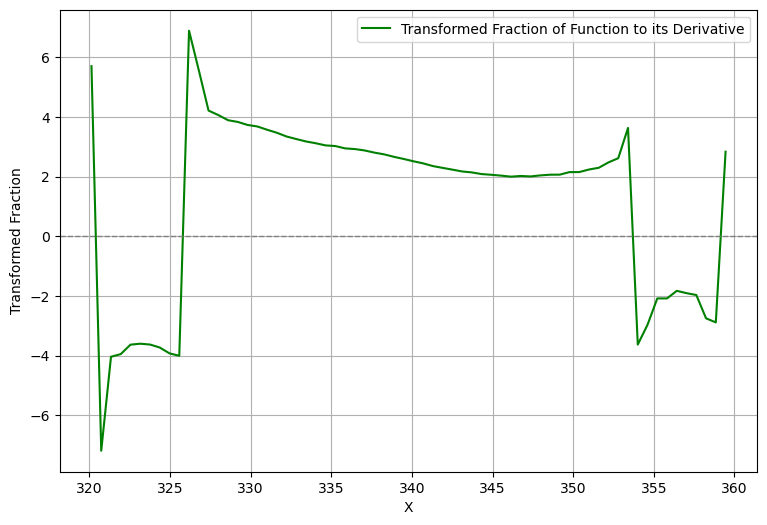

In [1516]:

# Define a range of x values for plotting
x_range = np.linspace(np.min(shifted_pdf[:, 0]), np.max(shifted_pdf[:, 0]), 100)

# Compute the ratio for each x value in the range
ratios = [ratio_function(x, growth_optimizer_payoff_shift) for x in x_range]

# Apply logarithm to the absolute value and restore the sign
log_ratios = np.sign(ratios) * np.log(np.abs(ratios))

# Plot the transformed ratios
plt.figure(figsize=(9, 6))
plt.plot(x_range, log_ratios, 'green', label='Transformed Fraction of Function to its Derivative')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  # y=0 because log(1) = 0

plt.xlabel("X")
plt.ylabel("Transformed Fraction")
plt.legend(loc="best")
plt.grid(True) 
plt.show()


In [1517]:
def maximum_of_function(f):
    def negative_function(x):
        return -f(x)

    # Find the maximum using minimize_scalar within the bounds of your data
    result = minimize_scalar(negative_function, bounds=(np.min(growth_optimizer_payoff_shift.x), np.max(growth_optimizer_payoff_shift.x)), method='bounded')

    # The maximum value and the point where it is achieved
    max_value = -result.fun
    max_point = result.x
    
    return max_value, max_point

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_10124\90451916.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_shift, rv_fr) for x in x_range]


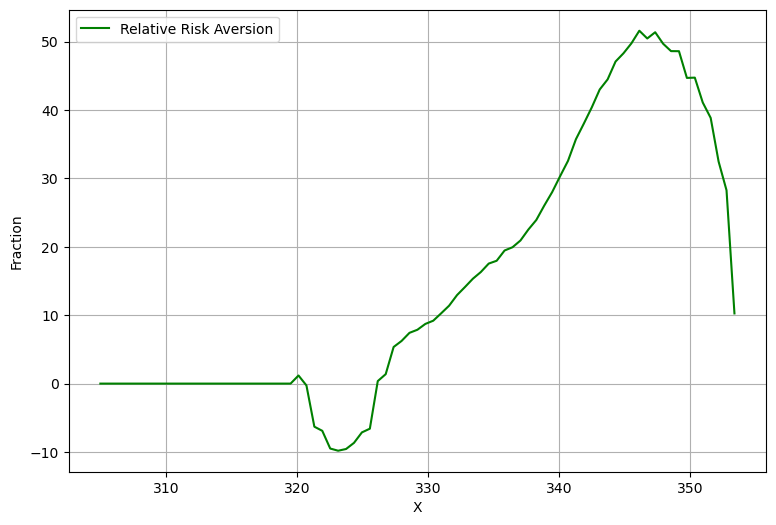

In [1518]:
max_value, K = maximum_of_function(growth_optimizer_payoff_shift)

def rv_fr(x):
    return derivative_to_payoff_ratio(x, K, K, 0.10*K, K)  

x_range = np.linspace(np.min(growth_optimizer_payoff_shift.x), np.max(growth_optimizer_payoff_shift.x), 100)
risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_shift, rv_fr) for x in x_range]

plt.figure(figsize=(9, 6))
plt.plot(x_range, risk_aversion, 'green', label='Relative Risk Aversion')
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True)

plt.show()


## Change volatility

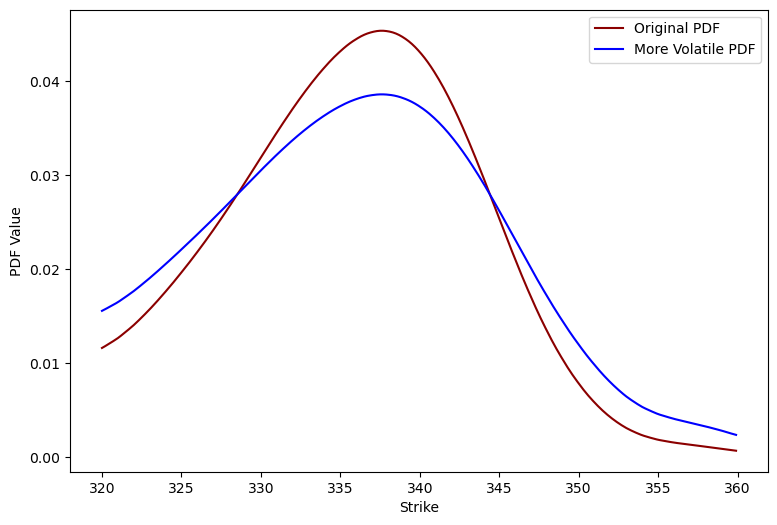

In [1519]:
# Step 1: Increase volatility with a non-linear transformation
volatility_increase = 1.5  # Adjust this for more or less volatility
new_pdf_values = np.copy(original_pdf[:, 1])
new_pdf_values = np.power(new_pdf_values, 1 / volatility_increase)

# Step 2: Normalize the new PDF
original_area = trapz(original_pdf[:, 1], original_pdf[:, 0])
new_area = trapz(new_pdf_values, original_pdf[:, 0])
new_pdf_values *= (original_area / new_area)

# Step 3: Create the more volatile PDF
more_volatile_pdf = np.column_stack((original_pdf[:, 0], new_pdf_values))

# Step 4: Plot both PDFs for comparison
plt.figure(figsize=(9,6))
plt.plot(original_pdf[:, 0], original_pdf[:, 1], 'darkred', label='Original PDF')
plt.plot(more_volatile_pdf[:, 0], more_volatile_pdf[:, 1], 'blue', label='More Volatile PDF')
plt.xlabel('Strike')
plt.ylabel('PDF Value')
plt.legend()
plt.show()

In [1520]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF

# Interpolate the original PDF
original_pdf_interp = interp1d(original_pdf[:, 0], original_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the more volatile PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the more volatile PDF's strike prices
original_pdf_values_at_more_volatile = original_pdf_interp(more_volatile_pdf[:, 0])

# Perform the division
division = more_volatile_pdf[:, 1] / np.where(original_pdf_values_at_more_volatile != 0, 
                                              original_pdf_values_at_more_volatile, 1)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff_vol = interp1d(more_volatile_pdf[:, 0], division, kind='linear', fill_value='extrapolate')



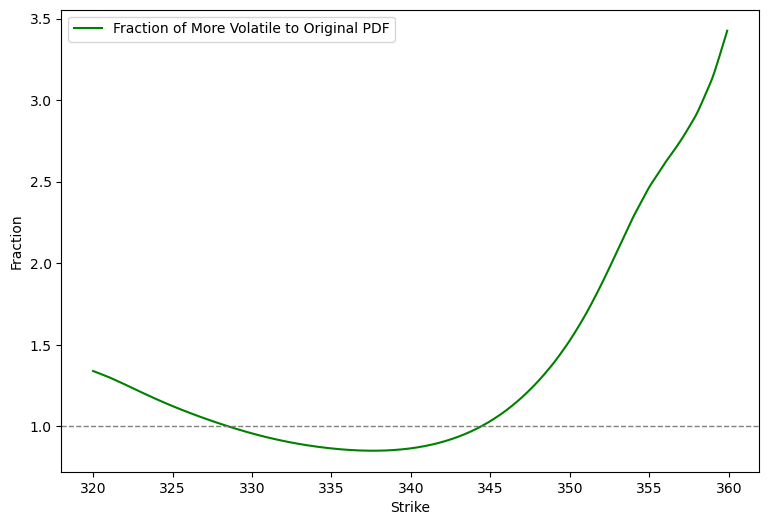

In [1521]:
# Plot the function
plt.figure(figsize=(9,6))

# Use a range of strike prices for plotting
strike_range = np.linspace(np.min(more_volatile_pdf[:, 0]), np.max(more_volatile_pdf[:, 0]), 500)
plt.plot(strike_range, growth_optimizer_payoff_vol(strike_range), 'green', label='Fraction of More Volatile to Original PDF')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Strike")
plt.ylabel("Fraction")
plt.legend(loc="best")
# plt.savefig("more_volatile_to_original_fraction.png", dpi=300)
plt.show()

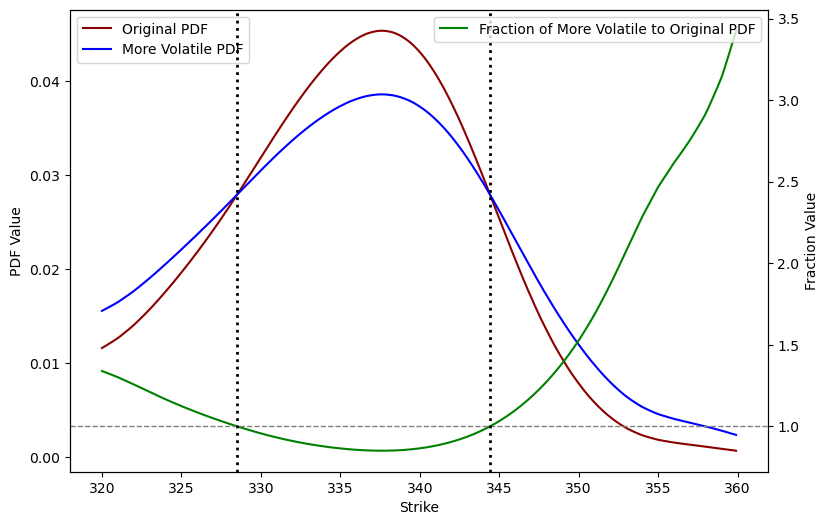

In [1522]:
#PLOT TOGETHER WITH SCALED PDFs


plt.figure(figsize=(9,6))

# Plot the Original PDF and More Volatile PDF
plt.plot(original_pdf[:, 0], original_pdf[:, 1], 'darkred', label='Original PDF')
plt.plot(more_volatile_pdf[:, 0], more_volatile_pdf[:, 1], 'blue', label='More Volatile PDF')

plt.xlabel("Strike")
plt.ylabel("PDF Value")
plt.legend(loc="upper left")

# Create secondary y-axis for the fraction
ax2 = plt.gca().twinx()

# Calculate and Plot the Fraction of More Volatile to Original PDF on the secondary y-axis
strike_range = np.linspace(np.min(more_volatile_pdf[:, 0]), np.max(more_volatile_pdf[:, 0]), 1000)
fractions = growth_optimizer_payoff_vol(strike_range)
ax2.plot(strike_range, fractions, 'green', label='Fraction of More Volatile to Original PDF')

# Add a horizontal line at y=1 for reference on the secondary y-axis
ax2.axhline(y=1, color='gray', linestyle='--', linewidth=1)
ax2.set_ylabel("Fraction Value")
ax2.legend(loc="upper right")

# Add more visible vertical dotted lines where the fraction is approximately 1
tolerance = 0.001  # Very small tolerance for precision
equal_points = strike_range[np.abs(fractions - 1) < tolerance]
for x in equal_points:
    plt.axvline(x=x, color='black', linestyle=':', linewidth=2)

plt.show()


### Take implied risk aversion

In [1523]:
def ratio_function(x, growth_optimizer_payoff):
    # Function to compute the derivative
    def derivative_of_growth_optimizer(x):
        return derivative(growth_optimizer_payoff, x, dx=1e-6)
    
    # Function to compute the ratio of the original function to its derivative
    original_value = growth_optimizer_payoff(x)
    derivative_value = derivative_of_growth_optimizer(x)
    return original_value / derivative_value if derivative_value != 0 else np.inf

In [1524]:
def relative_risk_aversion(x, growth_optimizer_payoff, general_payoff_ratio):
    return ratio_function(x, growth_optimizer_payoff) * general_payoff_ratio(x)

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_10124\1726943306.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_vol, rv_fr) for x in x_range]


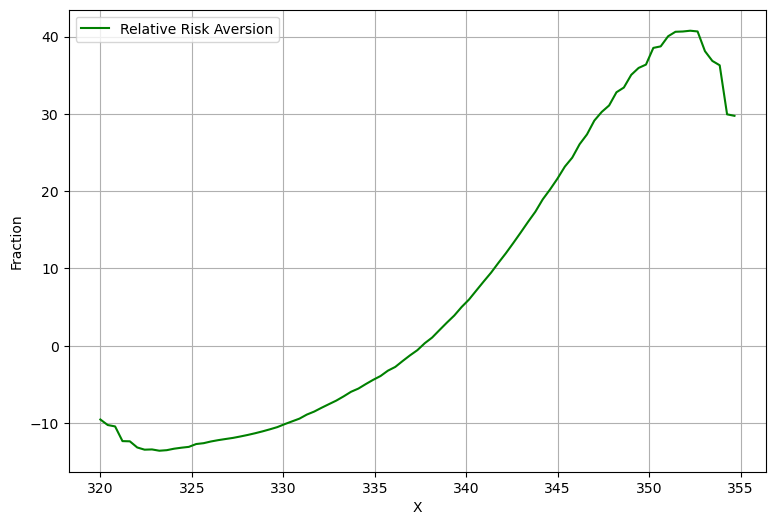

In [1529]:


K = 355

def rv_fr(x):
    return derivative_to_payoff_ratio(x, K, K, 0.10*K, K)  

x_range = np.linspace(np.min(growth_optimizer_payoff_vol.x), np.max(growth_optimizer_payoff_vol.x), 100)
risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_vol, rv_fr) for x in x_range]

plt.figure(figsize=(9, 6))
plt.plot(x_range, risk_aversion, 'green', label='Relative Risk Aversion')
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True)

plt.show()
